## [Dacon] AI프렌즈 시즌2 강수량 산출 경진대회
## JM 팀
## 2020년 05월 31일

[requirement.txt 다운로드 하기](https://drive.google.com/uc?export=download&id=1rXMmrhnghOW1foeMDYP0ZwrTnVfbImaq)

## 1. 라이브러리 불러오기

## Library Load

#### Library Version
- pandas : 0.24.2
- numpy : 1.18.1
- sklearn : 0.22.1
- tqdm : 4.42.1
- tensorflow : 2.1.0
- matplotlib : 3.0.3
- seaborn : 0.9.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import glob
import gc
import random
from tqdm import tqdm
import time
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error, confusion_matrix, recall_score, precision_score
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint  
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,BatchNormalization,LayerNormalization,Dropout,Conv2D,Conv2DTranspose, MaxPooling2D, Flatten,Activation, PReLU,concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import multi_gpu_model

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2" # 사용할 GPU 설정





In [2]:
# Metrics
# f1 score 계산
def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    return(f1_score(y_true, y_pred))
def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

# MAE/f1
def maeOverFscore(y_true, y_pred):
    return AIF_mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)
def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

# 실제값 0.1이상인 것에대한 MAE 값 계산
def AIF_mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def mae_custom(y_true, y_pred):
    score = tf.py_function(func=AIF_mae, inp=[y_true, y_pred], Tout=tf.float32,  name='mae_custom') 
    return score

# classification 모델의 fscore 계산
def fscore_(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    y_true = np.where(y_true >= 0.5, 1, 0)
    y_pred = np.where(y_pred >= 0.5, 1, 0)
    return(f1_score(y_true, y_pred))

def fscore_classification(y_true, y_pred):
    score = tf.py_function(func=fscore_, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_classification')
    return score

## 2. 데이터 로드 & 전처리
## Data Load & Pre-Processing  
- 결측값이 없는 온전한 데이터만 로드

In [3]:
def data_load(files, TRAIN=True):
    '''
    TRAIN : {True:훈련 데이터 로드, 결측값이 없는 온전한 데이터만 로드, False:테스트 데이터 로드, 모든 데이터 로드}
    '''
    tmp=[]
    for file in tqdm(files[:]):
        data = np.load(file).astype(np.float32)
        if TRAIN:
            if (data[:,:,-1]<0).sum()==0:                     # 결측값이 없는 데이터만 로드
                tmp.append(data)
        else:
            tmp.append(data)
    return np.array(tmp)

In [4]:
# 결측값이 없는 데이터만 Load
train_files = sorted(glob.glob('data/train/*.npy'))[:]
train_ = data_load(train_files)
print('train shape :', train_.shape)

100%|██████████| 76345/76345 [00:56<00:00, 1340.68it/s]


train shape : (75957, 40, 40, 15)


## 3. 탐색적 자료분석
## Exploratory Data Analysis


#### 한 픽셀의 target 값이 0.1 이상인 행들만 선택하여 밝기온도 차와 target의 상관계수가 높은 순으로 시각화 하여 확인

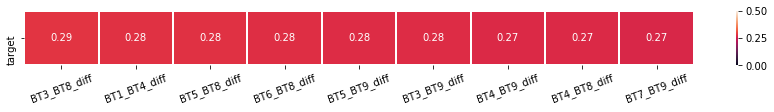

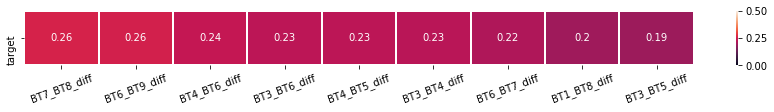

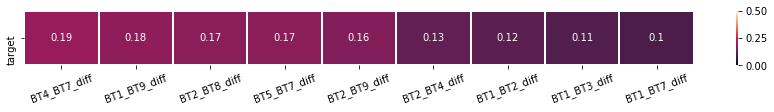

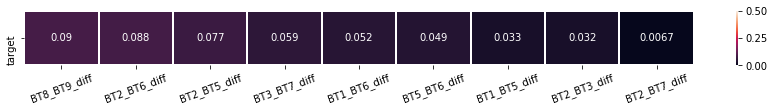

In [5]:
df = pd.DataFrame(train_.reshape(-1, 15))
df.columns=['BT1', 'BT2', 'BT3', 'BT4', 'BT5', 'BT6', 'BT7', 'BT8', 'BT9','type','GMI_lon', 'GMI_lat', 'DPR_lon', 'DPR_lat','target']
BT_column=['BT1', 'BT2', 'BT3', 'BT4', 'BT5', 'BT6', 'BT7', 'BT8', 'BT9']

# 밝기온도 차 컬럼 추가
for i in range(9):
    for j in range(i+1, 9):
        df['{}_{}_diff'.format(BT_column[i],BT_column[j])] = df[BT_column[i]] - df[BT_column[j]]

# target 값이 0.1 이상인 값만 추출
df = df[df['target']>=0.1]

# 상관계수 계산
df_corr = df.corr()
col = df_corr['target'].abs().sort_values(ascending=False).index

# 시각화
plt.rcParams['figure.figsize'] = [15, 1]
for idx in range(0, 36, 9):
    sns.heatmap(df_corr.loc[['target'],[k for k in col if 'diff' in k][idx:idx+9]].abs(), annot=True, linewidths=1, vmin=0, vmax=0.5)
    plt.xticks(rotation=20)
    plt.show()

#### GMI(경도,위도) plot에서의 강수량을 시각화 하여 확인. (강수량 수치가 클수록 색이 진하고 크기가 큰 점)
- 강수량이 중구난방 있지않고 비교적 밀집되어 있음을 알 수 있다. --> CNN 기반 딥러닝 모델 학습이 용이할 것 같다. --> Unet 모델 사용


In [6]:
def visualize(idx):
    plt.figure(figsize=(10,10))
    pal = sns.dark_palette("palegreen", as_cmap=True)
    colormap = plt.cm.RdBu
    sns.scatterplot(train_[idx,:,:,10].reshape(-1), train_[idx,:,:,11].reshape(-1), hue=train_[idx,:,:,-1].reshape(-1), size=train_[idx,:,:,-1].reshape(-1))
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.show()

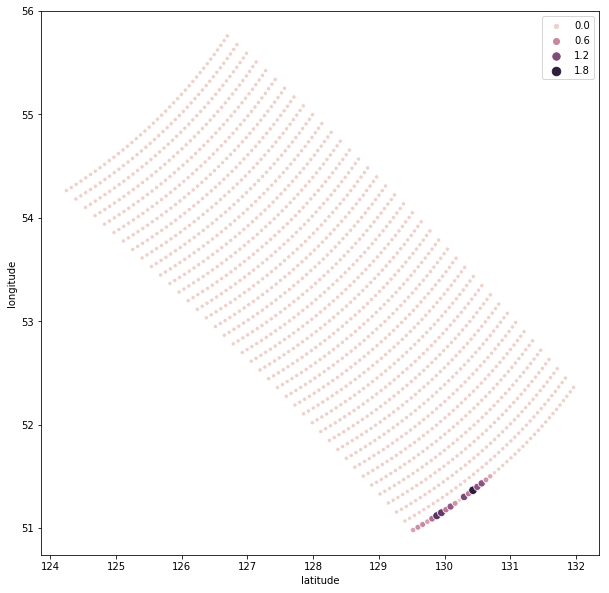

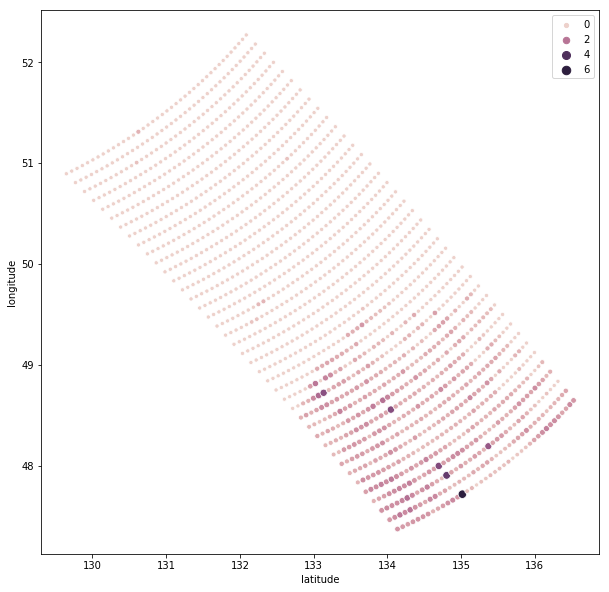

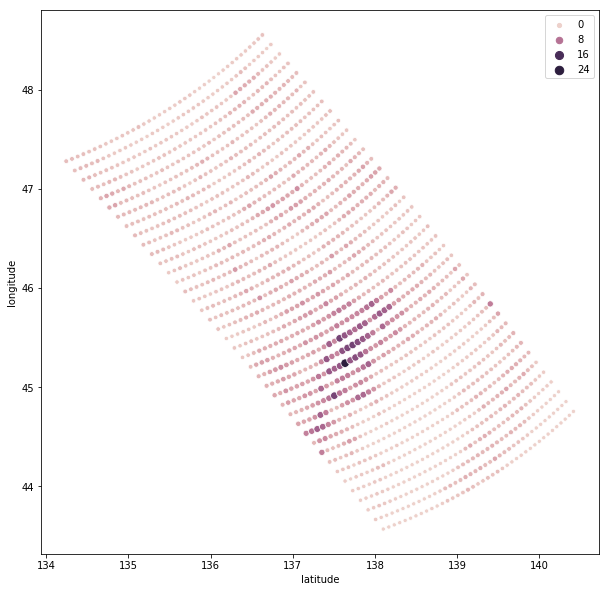

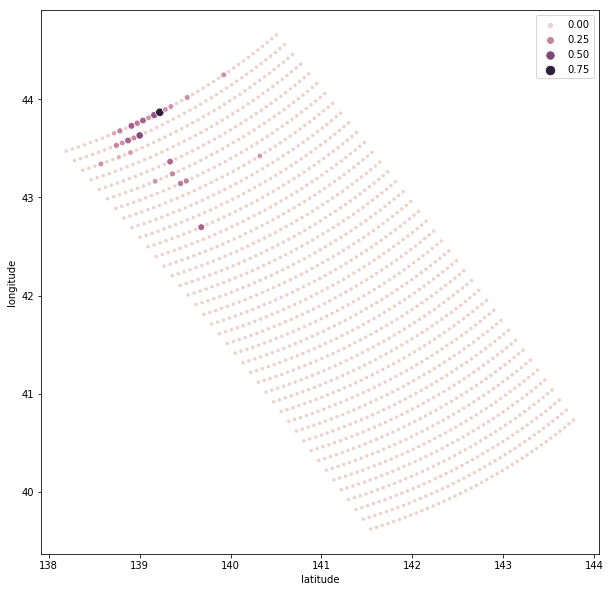

In [7]:
visualize(9502)
visualize(9503)
visualize(9504)
visualize(9505)


## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

#### 변수 선택 및 feature 생성 함수
- 밝기온도 차이와 target 사이에서 상관계수가 높은 24개를 선택
- [(3,8), (5,8), (1,4), (6, 8), (5, 9), (3, 9), (4, 9), (4, 8), (7, 9), (7,8), (6, 9), (4, 6), (3, 6), (4, 5), (3, 4),(6, 7), (1, 8), (3, 5), (4, 7), (1, 9), (2, 8), (5, 7), (2, 9), (2, 4)]

- 지표타입 feature은 get_dummy를 통해 one-hot encoding

In [5]:
def gen_feature(data, type_encoding=True):
    #  밝기온도와 target의 상관 계수가 높은 24개를 생성.
    '''
    type_encoding : 지표 타입을 get_dummy를 사용하여 인코딩 할지 여부.
    '''
    tmp = []
    for bt in tqdm([(3,8), (5,8), (1,4), (6, 8), (5, 9), (3, 9), (4, 9), (4, 8), (7, 9), (7,8), (6, 9), (4, 6), (3, 6), (4, 5), (3, 4),
              (6, 7), (1, 8), (3, 5), (4, 7), (1, 9), (2, 8), (5, 7), (2, 9), (2, 4)]):
        tmp.append(data[:,:,:,bt[0]-1]-data[:,:,:,bt[1]-1])
    tmp = np.array(tmp).reshape(-1, 40, 40, 24)

    # type one-hot-encoding
    if type_encoding:
        TYPE = pd.get_dummies((data[:,:,:,9]//100).reshape(-1)).values
        TYPE = TYPE.reshape(-1,40,40,4)
        data = np.append(data[:,:,:,:9], data[:,:,:,10:],axis=-1)            # 원래 type을 제외
        data = np.append(TYPE, data, axis=-1)                                 # 타입 합치기
        data = np.append(tmp,data, axis=-1)                                   # 밝기온도 차이 합치기
    else:
        data = np.append(tmp,data, axis=-1)                                   
    return data

In [6]:
train_type_enc = gen_feature(train_, type_encoding=True)
train_non_type_enc = gen_feature(train_, type_encoding=False)

100%|██████████| 24/24 [00:12<00:00,  1.85it/s]


In [7]:
train_type_enc.shape, train_non_type_enc.shape

((75957, 40, 40, 42), (75957, 40, 40, 39))

In [8]:
del train_
gc.collect()

36

#### Data Agumentation 전 train과 valid 데이터 index로 사전 분리 (5Fold)
- train_idx, valid_idx로 저장해두고 훈련 시 불러와 사용.

In [9]:
# Kfold split
skf_seed42 = KFold(n_splits=5, shuffle= True, random_state=42)                 # kfold, random_state 설정
skf_seed1030 = KFold(n_splits=5, shuffle= True, random_state=1030)                 # kfold, random_state 설정
skf_seed1234 = KFold(n_splits=5, shuffle= True, random_state=1234)                 # kfold, random_state 설정

kfolds_seed42 = []
kfolds_seed1030 = []
kfolds_seed1234 = []

for train_idx, test_idx in skf_seed42.split(range(len(train_type_enc))):
    kfolds_seed42.append((train_idx, test_idx))
for train_idx, test_idx in skf_seed1030.split(range(len(train_type_enc))):
    kfolds_seed1030.append((train_idx, test_idx))
for train_idx, test_idx in skf_seed1234.split(range(len(train_type_enc))):
    kfolds_seed1234.append((train_idx, test_idx))


#### Data Augmentation
- target에서 0.1 이상인 픽셀이 50개 이상일 경우 Data Augmentation 한다.
- horizontal flip
- vertical flip
- rotation 90, 180 270
- vertical flip + rotation90
- vertical flip + rotation270
- 증량된 데이터는 기존 train 데이터와 합치고 섞는다.

In [10]:
def augmentation(X, y):
    tmp = []
    for idx in range(len(X)):
        if (y[idx]>=0.1).sum()>=50:
            tmp.append(idx)

    X_train_aug90 = np.rot90(X[tmp], k=1, axes=(1,2))
    y_train_aug90 = np.rot90(y[tmp], k=1, axes=(1,2))
    X_train_aug180 = np.rot90(X[tmp], k=2, axes=(1,2))
    y_train_aug180 = np.rot90(y[tmp], k=2, axes=(1,2))
    X_train_aug270 = np.rot90(X[tmp], k=3, axes=(1,2))
    y_train_aug270 = np.rot90(y[tmp], k=3, axes=(1,2))
    X_train_flipV = np.flip(X[tmp],1)
    y_train_flipV = np.flip(y[tmp],1)
    X_train_flipH = np.flip(X[tmp],2)
    y_train_flipH = np.flip(y[tmp],2)
    X_train_flipV_90 = np.rot90(X_train_flipV, k=1, axes=(1,2))
    y_train_flipV_90 = np.rot90(y_train_flipV, k=1, axes=(1,2))
    X_train_flipV_270 = np.rot90(X_train_flipV, k=3, axes=(1,2))
    y_train_flipV_270 = np.rot90(y_train_flipV, k=3, axes=(1,2))

    # 증량 시킨 데이터들을 concatenate
    X = np.concatenate([X, X_train_aug90, X_train_aug180, X_train_aug270, X_train_flipV, X_train_flipH, X_train_flipV_90, X_train_flipV_270])
    y = np.concatenate([y, y_train_aug90, y_train_aug180, y_train_aug270, y_train_flipV, y_train_flipH, y_train_flipV_90, y_train_flipV_270])
    del X_train_aug90, y_train_aug90, X_train_aug180, y_train_aug180, X_train_aug270, y_train_aug270, X_train_flipV, y_train_flipV, X_train_flipH, y_train_flipH, X_train_flipV_90, y_train_flipV_90, X_train_flipV_270, y_train_flipV_270
    del tmp
    # agumentation data와 기존 train 데이터 합친것을 shuffle 하여 데이터들을 섞어준다.
    idx = np.array([k for k in range(len(X))]) 
    np.random.seed(1234)    
    np.random.shuffle(idx)
    X = X[idx]
    y = y[idx]
    return X, y

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation
- 기본 [Unet](https://arxiv.org/pdf/1505.04597.pdf) 구조를 사용하고 앞과 뒤 층을 수정
- input(40x40x41)을 UpSampling 하여 (80x80x41)을 Unet 기본 구조에 입력으로 한다.
- 마지막 층(80x80x1)에서 Maxpooling하여 DownSampling 하고 (40x40x1)을 output으로 한다.


- Epochs : 100
- Batch Size : 456
- initial Learning rate : 0.001
- Learning rate Scheduler : [Polynomial Decay](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay) (Cosine decay restarts도 번갈아 가며 사용하여 ensemble)
- Optimizer : Adam (SGD는 수렴속도가 느려 사용에 어려움이 있었음)
- Activation function : ELU 혹은 ReLU를 사용
- Output : Regression or Classification
- Upsampling Layer : Nearest Neighbor interporation 
- dropout : 0.5

In [11]:
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"])  # multi GPU 설정

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')


##### Generate Regression model

In [12]:
def unet_regression(input_shape,activation='elu', weight=False):
    '''
    activation : relu or elu
    weight : 로드할 모델 가중치의 여부
    '''
    drop = 0.5
    with strategy.scope():
        unit1 = 64
        unit2 = 128
        unit3 = 256
        unit4 = 512
        unit5 = 1024

        inputs = Input(shape=(input_shape))
        inputs_ = UpSampling2D(size=(2,2))(inputs)
        conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs_)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation(activation)(conv1)
        conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation(activation)(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        pool1 = Dropout(drop)(pool1)
        conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation(activation)(conv2)
        conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation(activation)(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        pool2 = Dropout(drop)(pool2)
        conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation(activation)(conv3)
        conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation(activation)(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        pool3 = Dropout(drop)(pool3)
        conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation(activation)(conv4)
        conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation(activation)(conv4)
        drop4 = Dropout(drop)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        
        conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation(activation)(conv5)
        conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation(activation)(conv5)
        drop5 = Dropout(drop)(conv5)

        up6 = Conv2D(unit4, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        up6 = BatchNormalization()(up6)
        up6 = Activation(activation)(up6)
        merge6 = concatenate([drop4,up6], axis = 3)
        merge6 = Dropout(drop)(merge6)
        conv6 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation(activation)(conv6)
        conv6 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation(activation)(conv6)
        up7 = Conv2D(unit3, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        up7 = BatchNormalization()(up7)
        up7 = Activation(activation)(up7)
        merge7 = concatenate([conv3,up7], axis = 3)
        merge7 = Dropout(drop)(merge7)
        conv7 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation(activation)(conv7)
        conv7 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation(activation)(conv7)
        up8 = Conv2D(unit2, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        up8 = BatchNormalization()(up8)
        up8 = Activation(activation)(up8)
        merge8 = concatenate([conv2,up8], axis = 3)
        merge8 = Dropout(drop)(merge8)
        conv8 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation(activation)(conv8)
        conv8 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation(activation)(conv8)

        up9 = Conv2D(unit1, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        up9 = BatchNormalization()(up9)
        up9 = Activation(activation)(up9)
        merge9 = concatenate([conv1,up9], axis = 3)
        merge9 = Dropout(drop)(merge9)
        conv9 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation(activation)(conv9)
        conv9 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation(activation)(conv9)
        conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = BatchNormalization()(conv9) 
        conv9 = Activation(activation)(conv9)
        conv9 = MaxPooling2D(pool_size=(2, 2))(conv9)
        conv9 = BatchNormalization()(conv9)
        # regression output
        regression = Conv2D(1, 1, activation = 'relu', name='regression')(conv9)
        model = Model(inputs, regression)
        if weight==False:
            model.compile(loss='mae', optimizer=opt, metrics=[fscore_keras, maeOverFscore_keras, mae_custom] )
    return model


##### Generate Classification model

In [13]:
# Generate model
def unet_classification(input_shape,activation='elu', weight=False):
    '''
    activation : relu or elu
    weight : 로드할 모델의 가중치의 여부
    '''
    drop = 0.5
    with strategy.scope():
        unit1 = 64
        unit2 = 128
        unit3 = 256
        unit4 = 512
        unit5 = 1024

        inputs = Input(shape=(input_shape))
        inputs_ = UpSampling2D(size=(2,2))(inputs)
        conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs_)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation(activation)(conv1)
        conv1 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv1)
        conv1 = BatchNormalization()(conv1)
        conv1 = Activation(activation)(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        pool1 = Dropout(drop)(pool1)
        conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation(activation)(conv2)
        conv2 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv2)
        conv2 = BatchNormalization()(conv2)
        conv2 = Activation(activation)(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        pool2 = Dropout(drop)(pool2)
        conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation(activation)(conv3)
        conv3 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv3)
        conv3 = BatchNormalization()(conv3)
        conv3 = Activation(activation)(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        pool3 = Dropout(drop)(pool3)
        conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation(activation)(conv4)
        conv4 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(conv4)
        conv4 = BatchNormalization()(conv4)
        conv4 = Activation(activation)(conv4)
        drop4 = Dropout(drop)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
        
        conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation(activation)(conv5)
        conv5 = Conv2D(unit5, 3, padding = 'same', kernel_initializer = 'he_normal')(conv5)
        conv5 = BatchNormalization()(conv5)
        conv5 = Activation(activation)(conv5)
        drop5 = Dropout(drop)(conv5)

        up6 = Conv2D(unit4, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        up6 = BatchNormalization()(up6)
        up6 = Activation(activation)(up6)
        merge6 = concatenate([drop4,up6], axis = 3)
        merge6 = Dropout(drop)(merge6)
        conv6 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation(activation)(conv6)
        conv6 = Conv2D(unit4, 3, padding = 'same', kernel_initializer = 'he_normal')(conv6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Activation(activation)(conv6)
        up7 = Conv2D(unit3, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        up7 = BatchNormalization()(up7)
        up7 = Activation(activation)(up7)
        merge7 = concatenate([conv3,up7], axis = 3)
        merge7 = Dropout(drop)(merge7)
        conv7 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation(activation)(conv7)
        conv7 = Conv2D(unit3, 3, padding = 'same', kernel_initializer = 'he_normal')(conv7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Activation(activation)(conv7)
        up8 = Conv2D(unit2, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        up8 = BatchNormalization()(up8)
        up8 = Activation(activation)(up8)
        merge8 = concatenate([conv2,up8], axis = 3)
        merge8 = Dropout(drop)(merge8)
        conv8 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation(activation)(conv8)
        conv8 = Conv2D(unit2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv8)
        conv8 = BatchNormalization()(conv8)
        conv8 = Activation(activation)(conv8)

        up9 = Conv2D(unit1, 2, padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        up9 = BatchNormalization()(up9)
        up9 = Activation(activation)(up9)
        merge9 = concatenate([conv1,up9], axis = 3)
        merge9 = Dropout(drop)(merge9)
        conv9 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation(activation)(conv9)
        conv9 = Conv2D(unit1, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = BatchNormalization()(conv9)
        conv9 = Activation(activation)(conv9)
        conv9 = Conv2D(2, 3, padding = 'same', kernel_initializer = 'he_normal')(conv9)
        conv9 = BatchNormalization()(conv9) 
        conv9 = Activation(activation)(conv9)
        conv9 = MaxPooling2D(pool_size=(2, 2))(conv9)
        conv9 = BatchNormalization()(conv9)
        
        # classification output 
        classification = Conv2D(1, 1, activation = 'sigmoid', name='classification')(conv9)
        model = Model(inputs, classification)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[fscore_classification, 'accuracy'] )
    return model


##### Generator

In [14]:
def generator(x_data, y_data, batch_size):
    size=len(x_data)
    while True:
        for i in range(size//batch_size):
            x_batch = x_data[i*batch_size: (i+1)*batch_size]
            y_batch = y_data[i*batch_size: (i+1)*batch_size]
            yield x_batch, y_batch

#### y 값 세팅 함수. 
- regression : raw 값 그대로
- classification : 0.1 이상의 값은 1 나머지 0

In [15]:
def set_y_value(y, mode):
    '''
    mode: {A:regression, B:classification}
    '''
    if mode=='A':
        return y
    elif mode == 'B':
        return np.where(y>=0.1, 1, 0)
    else:
        print('Select mode [A, B]')

### Regression 모델 학습
- type encoding 한 것 -> 41개의 feature
- type encoding 안 한것 -> 38개의 feature
- 대회 초반 38개의 feature로 학습하다가 대회 후반  41개의 feature로 학습하니 성능이 개선돼 후반부는 41개의 feature로만 학습을 진행. --> 38개로 할 때는 augmentation을 안해서 성능이 낮게 나온 점도 있음.
- type(지표타입) feature encoding한 데이터
    - 서로 다른 random_state로 train과 valid를 나눈데이터에서 5개의 fold를 학습 시킨 것 11개를 ensemble하기 위해 가중치를 저장.
- type(지표타입) feature encoding 하지 않은 데이터 
    - 서로 다른 random_state로 train과 valid를 나눈데이터에서 5개의 fold를 학습 시킨 것 4개를 ensemble하기 위해 가중치를 저장.
- random_state의 변화를 준 것은 데이터를 분포를 다르게 함으로써 모델이 학습하는 데이터에 변화를 주어 앙상블 효과를 보기 위함.

## ※
- augmentation시 많은 컴퓨터 자원을 필요로함. 
- 한번에 모든 fold를 원활히 학습하기 위해서는 메모리가 128g++ 이상으로 충분해야 함.

#### regression model - 지표타입 feature encoding X
- 서로 다른 random_state로 train과 valid를 나눈 데이터에서 3번 째 폴드마다 activation을 relu로 학습하여 저장. 나머지는 elu
- 지표타입 encoding 하지 않은 38개 feature의 학습은 대회 초반부에 학습된 모델이어서 augmentation을 진행하지 않았었음. --> augmentation을 하면 성능이 좀 더 높아 질 것이라 생각됨.
- 저장된 가중치가 augmentation을 하지 않은 채로 학습된 것이기 때문에 내용 복원을 위해 해당 코드에서는 augmentation은 하지 않음. --> augmentation 부분을 주석 해제하고 하는 것이 성능 향상에 도움이 있을 것임


In [ ]:
batch_size=456
epochs=100
for idx, kfolds in enumerater([kfolds_seed1234]):
    for fold in range(1,5):
        # X_train, y_train fold별로 불러오기.
        X_train, y_train = train_non_type_enc[kfolds[fold-1][0],:,:,:-1], train_non_type_enc[kfolds[fold-1][0],:,:,-1]
        X_valid, y_valid = train_non_type_enc[kfolds[fold-1][1],:,:,:-1], train_non_type_enc[kfolds[fold-1][1],:,:,-1]
#         X_train, y_train = augmentation(X_train, y_train)      # Augmentation 적용


        decay_st = (len(X_train)//batch_size+1)*epochs
        poly_sche = tf.keras.optimizers.schedules.PolynomialDecay(0.001, decay_st, end_learning_rate=1e-6, power=0.9)
        opt = tf.keras.optimizers.Adam(poly_sche)
        

        # setting y value
        y_train_regression, y_valid_regression = set_y_value(y_train, mode='A'), set_y_value(y_valid, mode='A')
        print('X_train shape : ', X_train.shape)
        print('X_valid shape : ', X_valid.shape)
        
        # generate Model
        if fold==3:
            regression_model = unet_regression(input_shape=X_train.shape[1:], activation='relu')
        else:
            regression_model = unet_regression(input_shape=X_train.shape[1:], activation='elu')
        
        train_data = generator(X_train, y_train_regression, batch_size)
        
        # Fitting model
        regression_history = regression_model.fit(train_data,
                  validation_data = [X_valid, y_valid_regression], 
                   epochs=epochs+5, steps_per_epoch=len(X_train)//batch_size+1
                 )
        if fold==3:
            regression_model.save_weights('data/model_weights/poly_relu_38feature_{}_{}.hdf5'.format(idx, fold))
        else:
            regression_model.save_weights('data/model_weights/poly_elu_38feature_{}_{}.hdf5'.format(idx, fold))

#### regression model - Type feature encoding O 
- 서로 다른 random_state로 train과 valid를 나눈 데이터에서 3번 째 fold 마다 CosR learning rate decay 방식을 사용. 나머지는 polynomial decay


In [ ]:

batch_size=456
epochs=100

for idx, kfolds in enumerate([kfolds_seed1234, kfolds_seed42, kfolds_seed1030]):
    for fold in range(1,5):
        if (idx==2) & (fold==4):
            break
        # X_train, y_train fold별로 불러오고 augmentation
        X_train, y_train = train_type_enc[kfolds[fold-1][0],:,:,:-1], train_type_enc[kfolds[fold-1][0],:,:,-1]
        X_valid, y_valid = train_type_enc[kfolds[fold-1][1],:,:,:-1], train_type_enc[kfolds[fold-1][1],:,:,-1]
        X_train, y_train = augmentation(X_train, y_train)
        
        # 3번 째 폴드마다 Cosine Restarts 방법을 사용하여 learning rate 를 조절 나머지는 polynomial decay
        if fold==3:
            cosine_restarts_decay_step = ((((len(input_shape)//batch_size)+1)*epochs)//7)+1
            cosine_restarts = tf.keras.experimental.CosineDecayRestarts(0.001, cosine_restarts_decay_step, t_mul=2.0, m_mul=0.9, alpha=0,name=None)
            opt = tf.keras.optimizers.Adam(cosine_restarts)
        else:
            decay_st = (len(X_train)//batch_size+1)*epochs
            poly_sche = tf.keras.optimizers.schedules.PolynomialDecay(0.001, decay_st, end_learning_rate=1e-6, power=0.9)
            opt = tf.keras.optimizers.Adam(poly_sche)
        

        
        # setting y value
        y_train_regression, y_valid_regression = set_y_value(y_train, mode='A'), set_y_value(y_valid, mode='A')
        print('X_train shape : ', X_train.shape)
        print('X_valid shape : ', X_valid.shape)

        # generate Model
        regression_model = unet_regression(input_shape=X_train.shape[1:], activation='elu')
        train_data = generator(X_train, y_train_regression, batch_size)
        
        # Fitting model
        regression_history = regression_model.fit(train_data,
                  validation_data = [X_valid, y_valid_regression], 
                   epochs=epochs+5, steps_per_epoch=len(X_train)//batch_size+1
                 )
        if fold==3:
            regression_model.save_weights('data/model_weights/augmentation_CosR_elu_41feature_{}_{}.hdf5'.format(idx, fold))
        else:
            regression_model.save_weights('data/model_weights/augmentation_poly_elu_41feature_{}_{}.hdf5'.format(idx, fold))
        
        

        del X_train, y_train, X_valid,y_valid
        gc.collect()

#### Classification model
- 분류모델은 타입지표를 인코딩한 것만 사용. augmentation을 하여 데이터도 증량
- 대회 막바지 시간이 없어 앙상블에 사용할 분류모델 1개만 훈련
- activation은 elu로 고정
- polynomial decay를 사용하여 learning rate를 줄여나감.
- Epoch 3번을 주기로 val_fscore_classification로 정의한 custom_metrics로 성능을 확인하여 성능 개선이 있을 경우 모델의 가중치를 저장.

In [ ]:
# setting parameters
batch_size=456
epochs=100

cp = ModelCheckpoint("classification_model({epoch:02d})val_fscore_classification({val_fscore_classification:.5f}).hdf5", 
                     monitor='val_fscore_classification', verbose=1, save_best_only=True, mode='max', period=3)    # save model weights

fold=1
X_train, y_train = train_type_enc[kfolds_seed1234[fold-1][0],:,:,:-1], train_type_enc[kfolds_seed1234[fold-1][0],:,:,-1]
X_valid, y_valid = train_type_enc[kfolds_seed1234[fold-1][1],:,:,:-1], train_type_enc[kfolds_seed1234[fold-1][1],:,:,-1]
X_train, y_train = augmentation(X_train, y_train)

# poly_scheduler 
decay_st = (len(X_train)//batch_size+1)*epochs
poly_sche = tf.keras.optimizers.schedules.PolynomialDecay(0.001, decay_st, end_learning_rate=1e-6, power=0.9)
opt = tf.keras.optimizers.Adam(poly_sche)


# setting y value
y_train_classification, y_valid_classification = set_y_value(y_train, mode='B'), set_y_value(y_valid, mode='B')
print('X_train shape : ', X_train.shape)
print('X_valid shape : ', X_valid.shape)



# generate Model
classification_model = unet_classification(input_shape=X_train.shape[1:],activation='elu')

train_data = generator(X_train, y_train_classification, batch_size)
# Fit model
classification_history = classification_model.fit(train_data,
          validation_data = [X_valid, y_valid_classification], 
           epochs=epochs+5, steps_per_epoch=len(X_train)//batch_size+1, callbacks=[cp]
         )

In [24]:
regression_history = regression_history.history
classification_history = classification_history.history

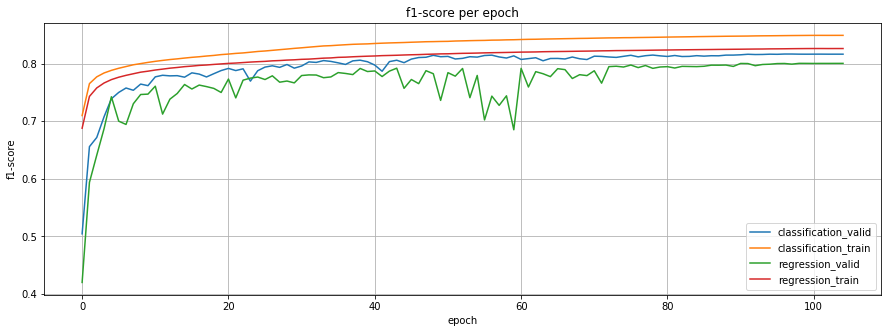

In [29]:
plt.plot(classification_history['val_fscore_classification'], label='classification_valid')
plt.plot(classification_history['fscore_classification'], label='classification_train')
plt.plot(regression_history['val_fscore_keras'], label='regression_valid')
plt.plot(regression_history['fscore_keras'], label='regression_train')
plt.title('f1-score per epoch')
plt.xlabel('epoch')
plt.ylabel('f1-score')
plt.legend()
plt.grid()
plt.show()

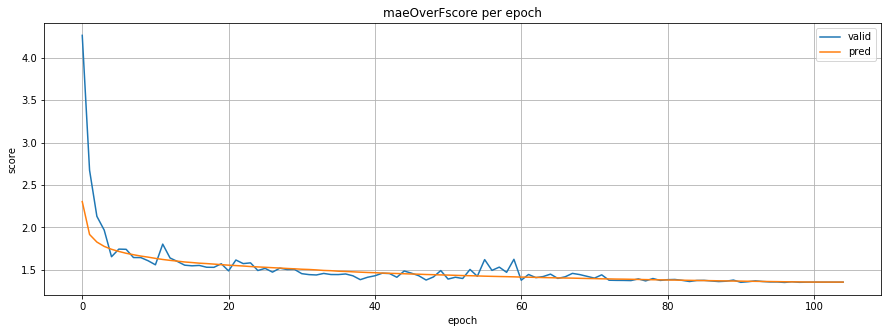

In [80]:
plt.figure(figsize=(15,5))
plt.plot(regression_history['val_maeOverFscore_keras'], label='valid')
plt.plot(regression_history['maeOverFscore_keras'], label='pred')
plt.title('maeOverFscore per epoch')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.grid()
plt.show()

## Test Predict

#### test data Augmentation soft voting ensemble &  predict
- test 데이터 또한 훈련 했던 데이터와 마찬가지로 augmentation을 한 후 soft-voting하여 결과를 내었습니다.


In [20]:
test_files = sorted(glob.glob('data/test/*.npy'))    # 데이터 파일
test = data_load(test_files, TRAIN=False)
print('test shape :', test.shape)
test = gen_feature(test,type_encoding=True)

 25%|██▌       | 6/24 [00:00<00:00, 58.65it/s]

test shape : (2416, 40, 40, 14)


100%|██████████| 24/24 [00:00<00:00, 25.96it/s]


In [63]:
def test_predict(model, test, augmentation=True):
    '''
    mode: {A:regression, B:classification}
    augmentation : test 데이터를 augmentation 한 결과를 예측하고 ensemble 시 True
    '''
    pred = model.predict(test).reshape(-1)
    if augmentation:
        pred_rot90 = model.predict(np.rot90(test,k=1,axes=(1,2)))
        pred_rot90 = np.rot90(pred_rot90, k=-1, axes=(1,2)).reshape(-1)
        pred_rot180 = model.predict(np.rot90(test,k=2,axes=(1,2)))
        pred_rot180 = np.rot90(pred_rot180, k=-2, axes=(1,2)).reshape(-1)
        pred_rot270 = model.predict(np.rot90(test,k=3,axes=(1,2)))
        pred_rot270 = np.rot90(pred_rot270, k=-3, axes=(1,2)).reshape(-1)
        pred_flipV = model.predict(np.flip(test,1))
        pred_flipV = np.flip(pred_flipV,1).reshape(-1)
        pred_flipH = model.predict(np.flip(test,2))
        pred_flipH = np.flip(pred_flipH,2).reshape(-1)
        pred_flipV_rot90 = model.predict(np.rot90(np.flip(test,1), k=1, axes=(1,2)))
        pred_flipV_rot90 = np.flip(np.rot90(pred_flipV_rot90, -1, axes=(1,2)), 1).reshape(-1)
        pred_flipV_rot270 = model.predict(np.rot90(np.flip(test,1), k=3, axes=(1,2)))
        pred_flipV_rot270 = np.flip(np.rot90(pred_flipV_rot270, -3, axes=(1,2)), 1).reshape(-1)
        result = (pred + pred_rot90 + pred_rot180 + pred_rot270 + pred_flipV + pred_flipH + pred_flipV_rot90 + pred_flipV_rot270)/8
    else:
        result = pred
    return result

In [ ]:
result_regression = test_predict(regression_model, test, augmentation=True)
result_classification = test_predict(classification_model, test, augmentation=True)

In [53]:
result_regression = np.where(((result_regression>=0.1) & (result_classification<=0.5)), 0.099999, result_regression)
result_regression = np.where(((result_regression<=0.1) & (result_classification>=0.5)), 0.1, result_regression)
result_regression = np.where(result_regression<0.1, 0.099999, result_regression)

##### model output

In [ ]:
# make submission file
submission = pd.read_csv('data/sample_submission.csv')
pred_df = pd.DataFrame(result_regression.reshape(-1,1600))
pred_df.id = submission['id']
pred_df.index = pred_df.id
pred_df.columns = submission.columns[1:]
pred_df.to_csv('submission_single.csv')

### JM 팀의 best score 결과물은 regression 모델 15개를 soft voting ensemble하여 최종 regression 결과물을 만들고, classification 모델 1개와 ensemble을 통해 최종 결과물을 생성.
- regression모델 과 classification 모델에서 validation data의 fscore를 기준으로 classification 모델이 fscore가 더 높은 것을 확인하고classification 모델에 더 가중치를 두고 결괏값을 생성.
- 만약 regression 결과 0.1 이상이지만 classification 모델이 0이라고 예측하면 0.1에 가까운 0.099999 값으로 생성.
- 만약 regression 결과 0.1 미만이지만 classification 모델이 1이라고 예측하면 0.1 로 생성
- 나머지 regression 값이 0.1 미만인 값은 0.099999로 생성.
- 0.099999 로 설정한 이유는 MAE 평가산식이 실제값 0.1 이상에 대해서만 평가 되기 때문에 fscore에 영향을 미치지 않으면서 MAE에 영향을 덜 받는 값인 0.099999로 최종 설정하였다.
- regression 모델 15개를 선정한 기준
    - 학습된 random_state와 fold를 달리하여 데이터 분포를 바꿔주면서 측정한 validation에서의 mae-over-fscore성능을 정렬하여 높은 15개를 선정하였다.
    - 이 중 4개는 augmentation을 하지 않고 38개의 feature를 사용 + activation 변화
    - 나머지 11개는 augmentation을 하고 41개의 feature를 사용 + lr scheduler 변화

### 훈련된 모델로 ensemble
### 15개의 앙상블 목록
- classification 모델은 따로 저장하지 않고 한 fold 학습한 것을 바로 사용.  

#### 파일 이름 설명
    - augmentation : target에서 0.1 이상인 픽셀이 50개 이상일 경우 Data Augmentation --> 이 경우 test의 데이터에서도 augmentation하여 앙상블 한것을 output 하였음
    - CosR or poly : learning rate decay 방법을 둘 중 하나를 선택
    - elu or relu : activation을 elu 혹은 relu로 선택
    - 41feature or 38 feature : 41개의 feature혹은 38개의 feature 선택  --> gen_feature 함수에서 Type Encoding 파라미터를 True로 하면 41, False로하면 38  
    
#### 목록
    - augmentation_poly_elu_41feature_1.hdf5
    - augmentation_poly_elu_41feature_2.hdf5
    - augmentation_CosR_elu_41feature_3.hdf5
    - augmentation_CosR_elu_41feature_4.hdf5
    - augmentation_CosR_elu_41feature_5.hdf5
    - augmentation_poly_elu_41feature_6.hdf5
    - augmentation_poly_elu_41feature_7.hdf5
    - augmentation_poly_elu_41feature_8.hdf5
    - augmentation_poly_elu_41feature_9.hdf5
    - augmentation_poly_elu_41feature_10.hdf5
    - augmentation_poly_elu_41feature_11.hdf5
    - poly_relu_38feature_1.hdf5
    - poly_elu_38feature_2.hdf5
    - poly_elu_38feature_3.hdf5
    - poly_elu_38feature_4.hdf5

In [64]:
weights = np.array(glob.glob('data/model_weights/*.hdf5'))           # 학습된 모델

In [66]:

result=0
test_files = sorted(glob.glob('data/test/*.npy'))    # 데이터 파일
for weight in weights:
    test = data_load(test_files, TRAIN=False)
    if '41feature' in weight:
        test = gen_feature(test,type_encoding=True)        # 38개 feature를 사용한 것은 지표타입은 get_dummy를 이용한 one-hot인코딩 O
    else:
        test = gen_feature(test,type_encoding=False)        # 38개 feature를 사용한 것은 지표타입은 get_dummy를 이용한 one-hot인코딩 X
    
    if 'relu' in weight:
        model=unet_regression(test.shape[1:],activation='relu', weight=True)
    else:
        model=unet_regression(test.shape[1:], activation='elu', weight=True)
    model.load_weights(weight)
    
    
    if 'augmentation' in weight:
        result += test_predict(model,test, augmentation=True)
    else:
        result += test_predict(model,test, augmentation=False)
    
result = result/15

100%|██████████| 24/24 [00:00<00:00, 61.66it/s]


In [73]:
result = np.where(((result>=0.1) & (result_classification<=0.5)), 0.099999, result)
result = np.where(((result<=0.1) & (result_classification>=0.5)), 0.1, result)
result = np.where(result<0.1, 0.099999, result)

In [75]:
submission = pd.read_csv('data/sample_submission.csv')
pred_df = pd.DataFrame(result.reshape(-1,1600))
pred_df.id = submission['id']
pred_df.index = pred_df.id
pred_df.columns = submission.columns[1:]
pred_df.to_csv('submission_JM.csv')

In [81]:
pred_df.head()

,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,px_10,...,px_1591,px_1592,px_1593,px_1594,px_1595,px_1596,px_1597,px_1598,px_1599,px_1600
id,,,,,,,,,,,,,,,,,,,,,
029858_01,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,...,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999
029858_02,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,...,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999
029858_03,0.099999,0.100000,0.142240,0.561316,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,...,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999
029858_05,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,...,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999
029858_07,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,0.099999,...,3.588916,3.786853,1.799870,0.878626,1.093513,2.857371,4.794459,3.543509,1.983038,1.068551


## 6. 결과 및 결언
## Conclusion & Discussion

- 데이터 증량과 feature 추가를 하여 컴퓨터 자원을 많이 필요하고 학습 시간이 오래 걸린다. (한 모델을 학습시 대략 12시간 내외)
- 많은 실험을 하며 validation score가 낮춰지는 방향으로 파라미터를 튜닝.
- regression single model의 결과
    - CV score : 1.36xxxx
    - public LB score : 1.478xxxx
- regression 1개 + classification 1개 ensemble
    - public LB score : 1.460xxxx
- regression 15개 + classification 1개 ensemble 결과
    - public LB score : 1.40xxxx 


###### 시도해 본 것들
- 한 픽셀을 하나의 행으로 만들어 Gradient Boosting 알고리즘 기반 tree 모델 (LGBM , XGB 등) 을 사용하여 regression 학습을 해보았지만 좋은 성능을 내기 어려웠음. 하지만 f1 score의 경우 어느 정도 성능이 나왔던것 같지만 시간이 없어 실험을 마무리 하지 못했음.
- 위 실험시 한 픽셀을 하나의 행으로 만들 때 주변 픽셀의 채널을 feature로 생성하여 주변 픽셀에 대해서도 학습 할 수 있도록 실험하였음.
- Unet모델에서 Upsampling 시 conv2dtranspose layer로 시도 해보았지만 validation의 score가 중간중간 튀는 모습이 보이고 안정적으로 떨어지지 않는 모습을 보임.